# Projet IA - Modèle d'Ising 2D - 2023/2024
Sorbonne Université - Master 1 - Physique Fondamentale et Applications

Guilherme Carvalho - Anatole Cremel-Schlemer - Panet Mathis

## Introduction - Code necessaire

In [4]:
# Importation des librairies
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall, Accuracy, AUC
from tensorflow.keras.utils import plot_model
from numba import njit

# Dossier de travail
file_dir = "./data/"

In [2]:
# Importation des données fournis
def read_t(t,root="./", str_check=False):
  if not str_check :
    data = pickle.load(open(root+'Ising2DFM_reSample_L40_T=%.2f.pkl'%t,'rb'))
  else :
    data = pickle.load(open(root+f'Ising2DFM_reSample_L40_T={t}.pkl','rb'))
  return np.unpackbits(data).astype(int).reshape(-1,1600)

data_all = read_t("All", file_dir, True)
data_label = pickle.load(open(file_dir+f'Ising2DFM_reSample_L40_T=All_labels.pkl','rb'))
print("Données importées")

Données importées


## Partie 1 : Génération de données

Nous allons voir dans cette partie comment générer des données avec le modèle d'Ising sans passer par l'algorithme de Metropolis. Un code C++ est aussi codé et accéléré mais il y a des petits bug sur l'enregistrement des données au niveau des bords. Le code est disponible sur le github.

### Génération python accéléré

La simulation est accélérée avec numba

#### Fonctions

In [3]:
@njit
def generer_tableau(ratio,size):
    nb = int(size*size*ratio)
    a = np.zeros(size*size)
    arr = np.arange(size*size)
    np.random.shuffle(arr)
    a[arr[:nb]]=1
    return a.reshape((size, size))


import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

@njit
def generer_tableau(ratio, size):
    nb = int(size * size * ratio)
    a = np.zeros(size * size)
    arr = np.arange(size * size)
    np.random.shuffle(arr)
    a[arr[:nb]] = 1
    return a.reshape((size, size))


@njit
def calcul_DE(tableau, x, y, size):
    if x == 0 or x == size - 1 or y == 0 or y == size - 1:
        extended_tab = np.zeros((size + 2, size + 2))
        extended_tab[1:size + 1, 1:size + 1] = tableau
        extended_tab[0, 1:size + 1] = tableau[-1]
        extended_tab[-1, 1:size + 1] = tableau[0]
        extended_tab[1:size + 1, 0] = tableau[:, size - 1]
        extended_tab[1:size + 1, size + 1] = tableau[:, 0]
        table_locale = extended_tab[x:x + 3, y:y + 3]
        o = table_locale[1, 1] * 2 - 1
        a = table_locale[0, 1] * 2 - 1
        b = table_locale[1, 0] * 2 - 1
        c = table_locale[1, 2] * 2 - 1
        d = table_locale[2, 1] * 2 - 1
    else:
        table_locale = tableau[x - 1:x + 2, y - 1:y + 2]
        o = table_locale[1, 1] * 2 - 1
        a = table_locale[0, 1] * 2 - 1
        b = table_locale[1, 0] * 2 - 1
        c = table_locale[1, 2] * 2 - 1
        d = table_locale[2, 1] * 2 - 1
    return 2 * o * (a + b + c + d)


@njit
def new_point_parallel(tableau, size, exp_values,nb_pas):
    for _ in prange(size * size * nb_pas):
        coordx = np.random.randint(size)
        coordy = np.random.randint(size)
        DE = calcul_DE(tableau, coordx, coordy, size)
        if test_precomputed(DE, exp_values):
            tableau[coordx, coordy] = not tableau[coordx, coordy]
    return tableau


@njit
def precomputed_exp_values(T):
    return np.array([np.exp(-4 / T), np.exp(-8 / T)])


@njit
def test_precomputed(DE, exp_values):
    if DE == 0 or DE == -4 or DE == -8:
        return True
    if DE == 4 or DE == 8:
        x = np.random.rand()
        return x < exp_values[int(DE / 4 - 1)]
    else:
        print("erreur, DE = ", DE)
        return False



@njit
def M(tableau, size):
    totplus = np.sum(tableau)

    return abs(-1 * (size * size - totplus) + totplus) / (size * size)


#### Génération

16it [00:53,  3.32s/it]


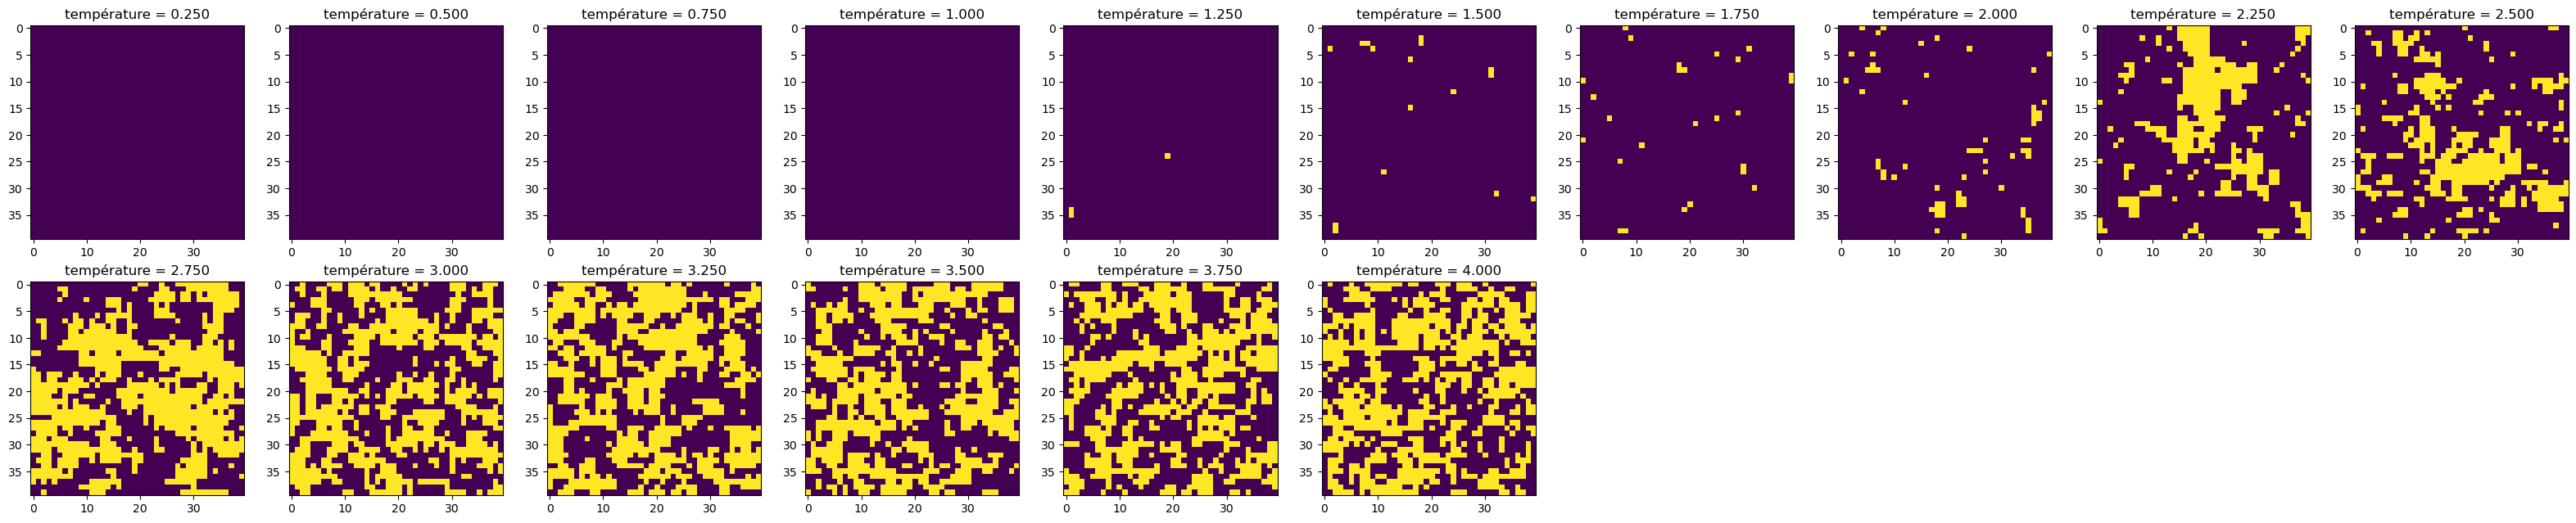

In [5]:
ratio_cases = 0.25

size = 40

tab = generer_tableau(ratio_cases, size)

nb_pas = 300 # un pas correspond à 1600 tentatives d'ajouts de nouveaux points
nb_data = 50

T_liste = np.linspace(0.25, 4,16)


Mliste=[]
plt.figure(figsize=[40,40])

for i,T in tqdm(enumerate(T_liste)):
    exp_values = precomputed_exp_values(T)
    for dat in range(nb_data):
        tab = generer_tableau(ratio_cases, size)
        tab = new_point_parallel(tab, size, exp_values,nb_pas)
        Mliste.append(np.sum(tab))
    plt.subplot(10,10,i+1)
    plt.imshow(tab)
    plt.title('température = {:.3f}'.format(T))

plt.show()

#### plot

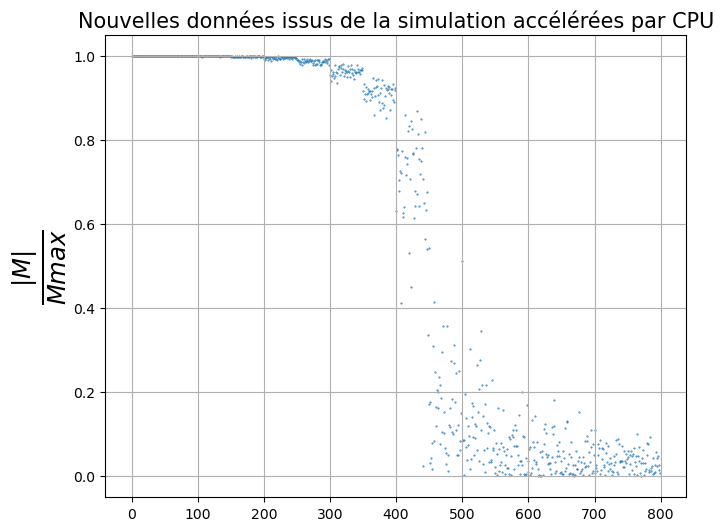

In [6]:
Mliste = (np.abs(np.array(Mliste)-800)*2)/1600

plt.figure(figsize=[7.5,6])
plt.scatter(np.arange(len(Mliste)),Mliste,s=0.2)
plt.ylabel(r'$\frac{|M|}{Mmax}$',size = 25)
plt.grid()
plt.title("Nouvelles données issus de la simulation accélérées par CPU",size = 15)
plt.show()

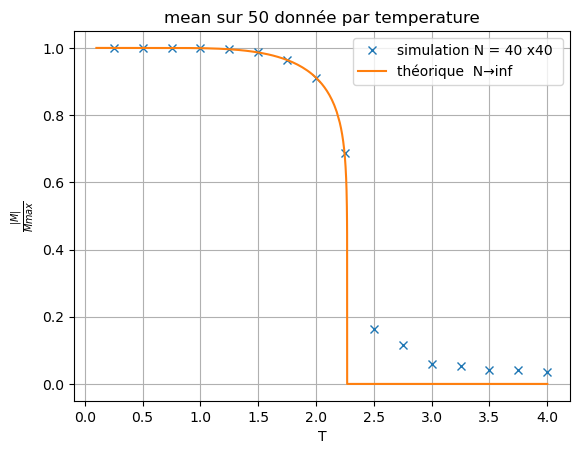

In [7]:
plt.plot(T_liste,Mliste.reshape(len(T_liste),nb_data).mean(axis=1),'x',label = "simulation N = 40 x40 ")

T = np.concatenate((np.linspace(0.1,2.2,100),np.linspace(2.2,2.26918478,100)))
x = (1-1/(np.sinh(2/T))**4)**(1/8)
plt.plot(list(T)+[2.269,3,3.5,3.7,4],list(x)+[0,0,0,0,0],label ="théorique  N→inf")


plt.xlabel('T')
plt.ylabel(r'$\frac{|M|}{Mmax}$')
plt.legend()
plt.grid()
plt.title('mean sur {} donnée par temperature'.format(nb_data))
plt.show()

### resultats et comparaison avec donnée du dataset

In [8]:
# Symétrisation des données (cf. Partie 2)

nom_temp = np.arange(0.25, 4.25, 0.25)

tot_data = np.empty((0,40,40))
tot_label = np.empty(0)

for T in nom_temp :
  tmp = read_t(T, file_dir)
  tot_data = np.concatenate((tot_data, tmp.reshape(tmp.shape[0], 40, 40)))
  tot_label = np.concatenate((tot_label, T*np.ones(tmp.shape[0])))

tot_data_sym = 2*np.abs(tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1) - 0.5)

In [11]:
# Importation des données générées

new_data = np.load("./new_data_accelerated.npy")
new_data.shape

(16000,)

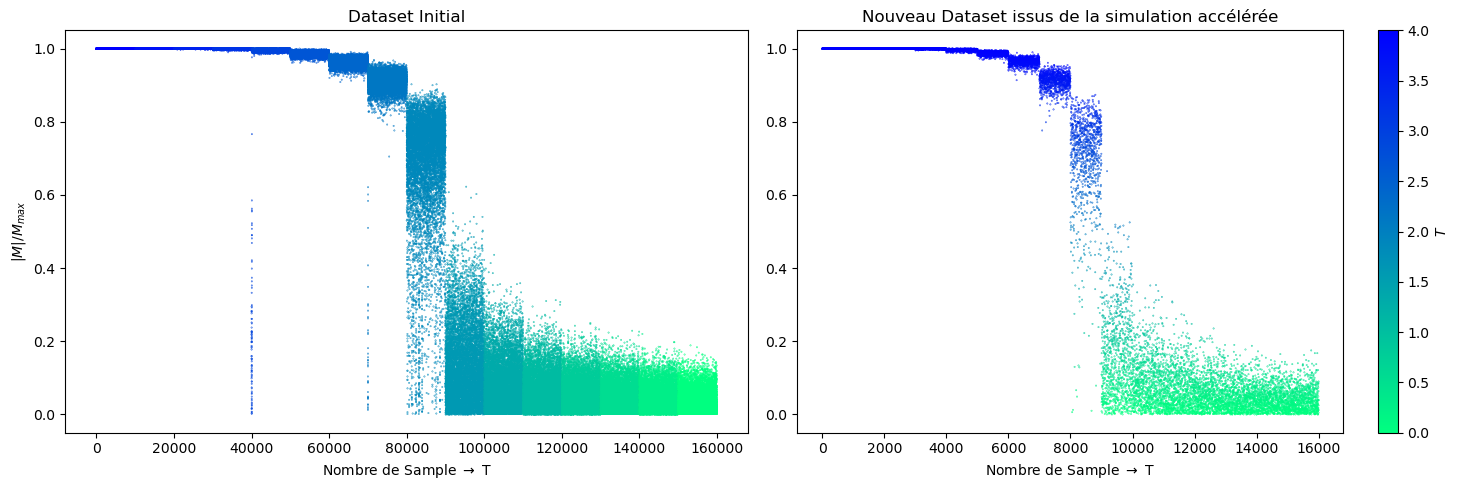

In [12]:
# Figure 1.6

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

cmap = mpl.colormaps['winter']
axs[0].scatter(range(tot_data_sym.shape[0]), tot_data_sym, c=tot_label, cmap=cmap, s=0.1)
axs[0].set_ylabel(r'$|M|/M_{max}$')
axs[0].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[0].set_title(r'Dataset Initial')

cmap = mpl.colormaps['winter_r']
axs[1].scatter(range(new_data.shape[0]), new_data, c=new_data, cmap=cmap, s=0.1)
axs[1].set_xlabel(r'Nombre de Sample $\rightarrow$ T')
axs[1].set_title(r'Nouveau Dataset issus de la simulation accélérée')

plt.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap=cmap), ax=axs[1], label=r'$T$')
plt.tight_layout()
plt.show()

## Partie 2 : Pré-traitement des données

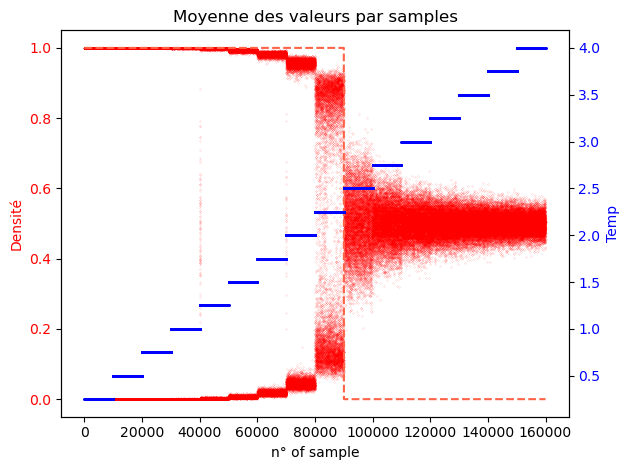

In [13]:
# Figure 2.1a
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité', color="red")
ax1.scatter(range(160000), tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1), s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title("Moyenne des valeurs par samples")

fig.tight_layout()
plt.show()

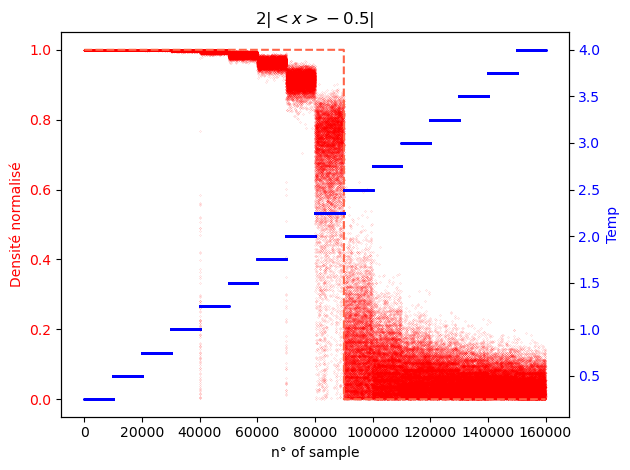

In [14]:
# Figure 2.1b
fig, ax1 = plt.subplots()

ax1.set_xlabel('n° of sample')
ax1.set_ylabel('Densité normalisé', color="red")
ax1.scatter(range(160000), tot_data_sym, s=.005, label="Mean value of samples", c="r")
ax1.plot(range(160000), data_label, "--", label="Labels", c='tomato')
ax1.tick_params(axis='y', labelcolor="r")

ax2 = ax1.twinx()

ax2.set_ylabel('Temp', color="b")
ax2.scatter(range(160000), tot_label, s=.1, label="Temps", c="b")
ax2.tick_params(axis='y', labelcolor="b")

ax1.set_title(r'$2 |<x> - 0.5|$')

fig.tight_layout()
plt.show()

## Partie 3 : Modèles classiques

### 3.1 Analyse par la magnétisation

In [15]:
# Mpdèle naif
mean_temperature = np.mean(tot_label)
predictions = np.full_like(tot_label, mean_temperature)

# Calculate the mean squared error
mse = mean_squared_error(tot_label, predictions)
print("MSE:", mse)

MSE: 1.328125


In [16]:
# Model linéaire sur les spins 
tot_data_sym_dim = np.c_[tot_data_sym.reshape(-1, 1), (tot_data_sym.reshape(-1, 1))**2, (tot_data_sym.reshape(-1, 1))**3, (tot_data_sym.reshape(-1, 1))**4]
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym_dim, tot_label, test_size=0.2, random_state=42)
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
predictions = linear_model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print("MSE :", mse)

MSE : 0.15078828385391982


In [17]:
# Modèle de Forêt Aléatoire
T_C = 2.269

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(tot_data_sym.reshape(-1,1), tot_label, test_size=0.2, random_state=42)

# Créer le modèle de régression de forêt aléatoire
forest_model = RandomForestRegressor(max_depth=5, bootstrap=True, n_estimators=100)

# Adapter le modèle aux données d'entraînement
forest_model.fit(X_train, y_train)

# Prédire sur les données de test
predictions = forest_model.predict(X_test)

# Classe réelle
real_class = np.where(y_test>T_C, 1, 0)

# Classe prédite
pred_class = np.where(predictions>T_C, 1, 0)

# Calculer l'erreur quadratique moyenne
mse = mean_squared_error(y_test, predictions)
print("mse:", mse)

kde_data = pd.DataFrame({'T':tot_label, 'Sym':tot_data_sym})
xnew = np.linspace(0, 1, 100)
ynew = forest_model.predict(xnew.reshape(-1, 1))

mse: 0.10819716992604919


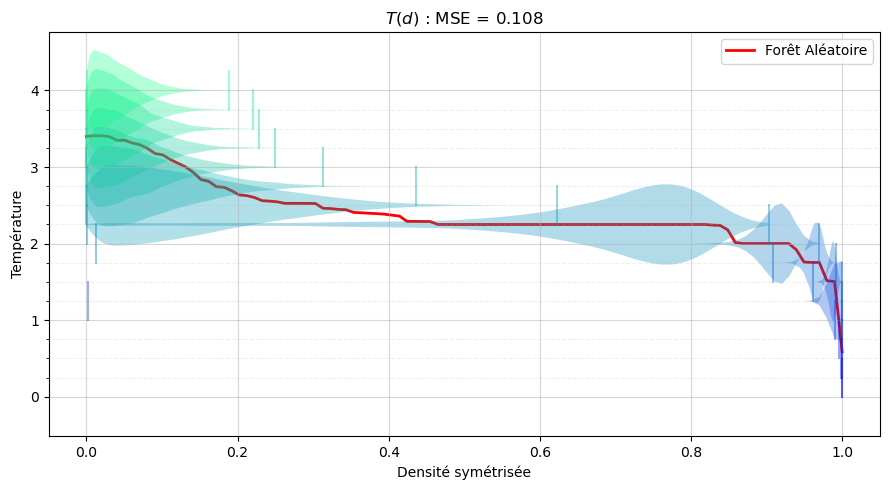

In [18]:
# Figure 3.1a
fig, ax = plt.subplots(figsize=(9, 5))
cmap = plt.get_cmap('winter', 16)

violinplots = []

for i in range(16):
    violinplot = ax.violinplot(
        kde_data[kde_data['T'] == nom_temp[i]]['Sym'],
        positions=[nom_temp[i]],
        showmeans=False,
        showextrema=True,
        widths=1.05,
        vert=False,
    )
    # Changer les couleurs en utilisant cmap
    violinplot['cmaxes'].set_color(cmap(i))
    violinplot['cmins'].set_color(cmap(i))
    violinplot['cbars'].set_color(cmap(i))
    for pc in violinplot['bodies']:
        pc.set_facecolor(cmap(i))
    # Changer l'épaisseur de ligne et l'opacité de la ligne
    violinplot['cmaxes'].set_alpha(0.4)
    violinplot['cmins'].set_alpha(0.4)
    violinplot['cbars'].set_alpha(0)
    
    violinplots.append(violinplot)

# Ajouter la ligne de la forêt aléatoire
ax.plot(xnew, ynew, color='r', linewidth=2, zorder=0, label="Forêt Aléatoire")

# Créer la légende
ax.legend()

# Ajouter des ticks mineurs à l'axe y
ax.set_yticks(nom_temp, minor=True)

ax.set_xlabel("Densité symétrisée")
ax.set_ylabel("Température")
ax.set_title(f"$T(d)$ : MSE = {mse:.3f}")

# Ajouter une grille aux ticks majeurs et mineurs
ax.grid(which='major', alpha=0.5, zorder=-1)
ax.grid(which='minor', alpha=0.2, linestyle='--', zorder=-1)

plt.tight_layout()
plt.show()

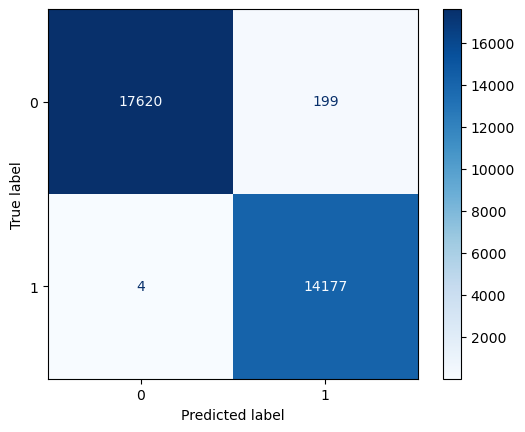

In [19]:
# Figure 3.1b
conf_mat = confusion_matrix(real_class, pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.show()

### 3.2 : Analyse par les spins

In [20]:
# Modele naif

percentage_class_1 = data_label[data_label == 1].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 1 : {percentage_class_1*100:.2f}%")
percentage_class_0 = data_label[data_label == 0].shape[0] / data_label.shape[0]
print(f"Pourcentage de classe 0 : {percentage_class_0*100:.2f}%")

# Create a naive model
def naive_model():
    if np.random.uniform() < percentage_class_1:
        return 1
    else:
        return 0

# Test the naive model
predictions = [naive_model() for _ in range(data_label.shape[0])]

print("MSE:", mean_squared_error(data_label, predictions))
print("Accuracy:", np.mean(data_label == predictions))

Pourcentage de classe 1 : 56.25%
Pourcentage de classe 0 : 43.75%
MSE: 0.4925875
Accuracy: 0.5074125


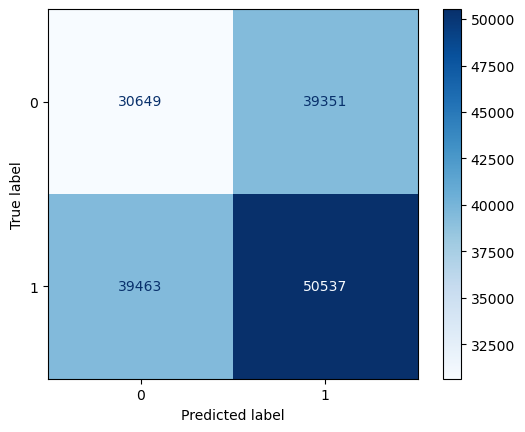

In [21]:
conf_mat = confusion_matrix(data_label, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot(cmap='Blues')
plt.savefig("random_matrix.png", dpi=300)
plt.show()

## Partie 4 : Réseaux de neurones

In [22]:
# Creation des données pour le modèle de CNN
mean_val = tot_data.reshape(tot_data.shape[0], 40*40).mean(axis=1)
tot_data = tot_data.astype(np.uint8)

tot_data[mean_val > 0.5] = np.invert(tot_data[mean_val > 0.5])//255

In [23]:
# Création du modèle de CNN
tot_data_cnn = tot_data.reshape(tot_data.shape[0], 40, 40, 1)

X_train, X_test, y_train, y_test = train_test_split(tot_data_cnn, data_label, test_size=0.2, random_state=42)

model = Sequential()
model.add(Conv2D(16, (5, 5), input_shape=(40, 40, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(128))
model.add(Dense(64))
model.add(Dense(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse', 'accuracy', Precision(), Recall(), AUC()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 40, 40, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 18, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 9, 9, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 3, 3, 64)          0

2023-12-19 20:32:41.696381: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 20:32:41.960243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 20:32:41.960476: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

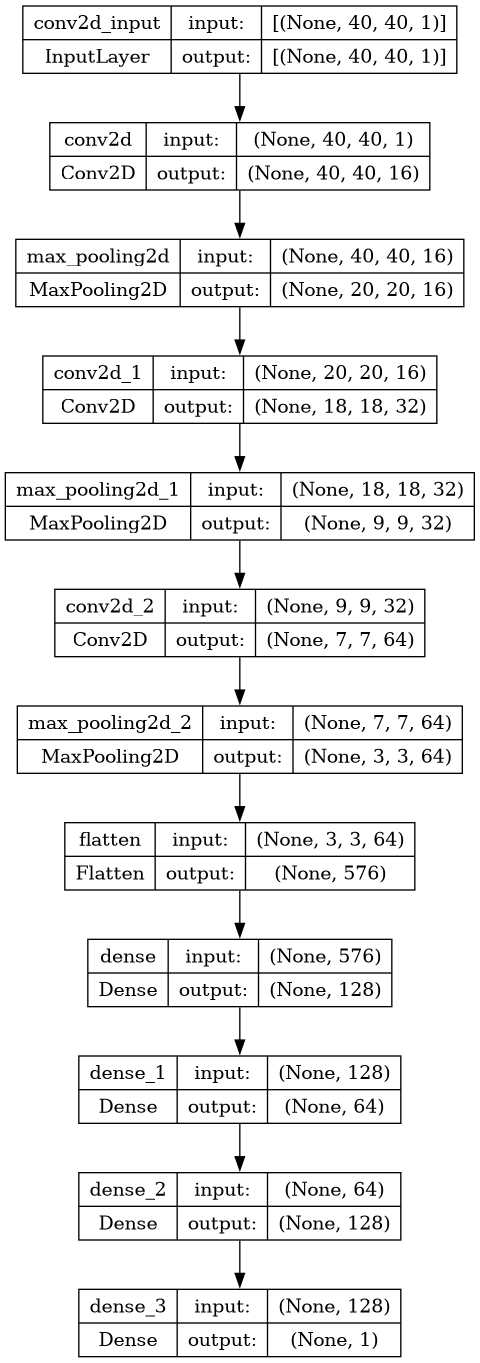

In [24]:
# Figure 4.1
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
# Entraînement du modèle de CNN
callback = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_split=0.2, callbacks = [callback])

Epoch 1/30


2023-12-19 20:32:43.821325: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2023-12-19 20:32:46.017446: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1428823ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-19 20:32:46.017465: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-12-19 20:32:46.040743: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-19 20:32:46.165863: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


800/800 [==============================] - 8s 4ms/step - loss: 0.0187 - mse: 0.0052 - accuracy: 0.9934 - precision: 0.9976 - recall: 0.9907 - auc: 0.9996 - val_loss: 0.0054 - val_mse: 0.0015 - val_accuracy: 0.9979 - val_precision: 0.9989 - val_recall: 0.9974 - val_auc: 1.0000
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0075 - mse: 0.0020 - accuracy: 0.9975 - precision: 0.9985 - recall: 0.9971 - auc: 0.9999 - val_loss: 0.0046 - val_mse: 0.0012 - val_accuracy: 0.9984 - val_precision: 0.9990 - val_recall: 0.9983 - val_auc: 0.9999
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0064 - mse: 0.0017 - accuracy: 0.9977 - precision: 0.9984 - recall: 0.9975 - auc: 0.9999 - val_loss: 0.0044 - val_mse: 0.0012 - val_accuracy: 0.9986 - val_precision: 0.9990 - val_recall: 0.9985 - val_auc: 1.0000
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.0052 - mse: 0.0014 - accuracy: 0.9982 - precision: 0.9988 - recall: 0.9

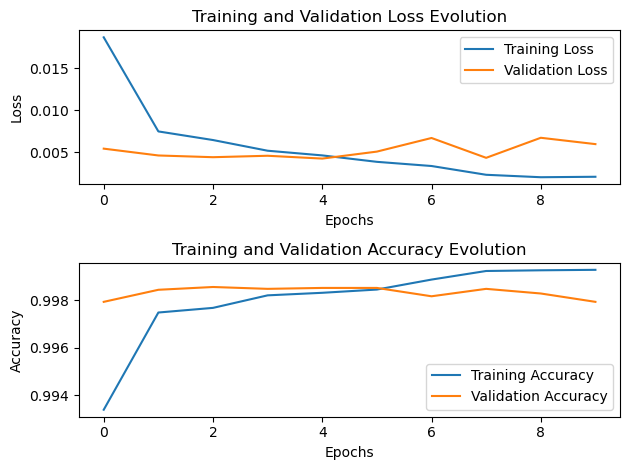

In [26]:
# Figure 4.2
plt.subplot(211)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Evolution')

plt.subplot(212)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Evolution')

plt.tight_layout()
plt.show()

In [27]:
# Affichage des métriques
test_loss, test_mse, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(X_test, y_test)
print('test loss', test_loss)
print('test mse', test_mse)
print('test accuracy', test_accuracy)
print('test precision', test_precision)
print('test recall', test_recall)
print('test auc', test_auc)

1000/1000 [==============================] - 2s 1ms/step - loss: 0.0058 - mse: 0.0015 - accuracy: 0.9980 - precision: 0.9995 - recall: 0.9970 - auc: 0.9998
test loss 0.005848001688718796
test mse 0.0014984796289354563
test accuracy 0.9980312585830688
test precision 0.9994936585426331
test recall 0.9969695210456848
test auc 0.9998190999031067


1000/1000 [==============================] - 1s 745us/step


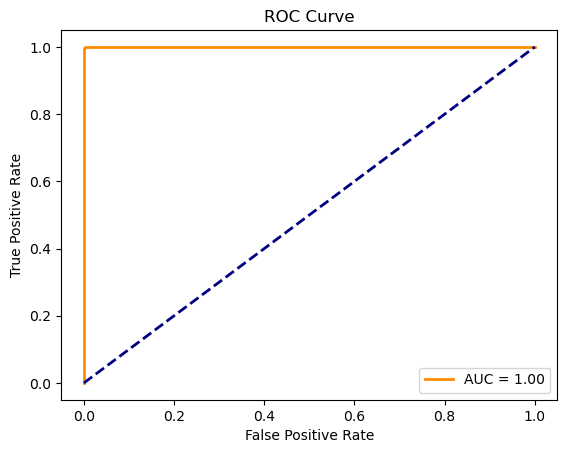

In [28]:
# Figure 4.4
y_pred = model.predict(X_test)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

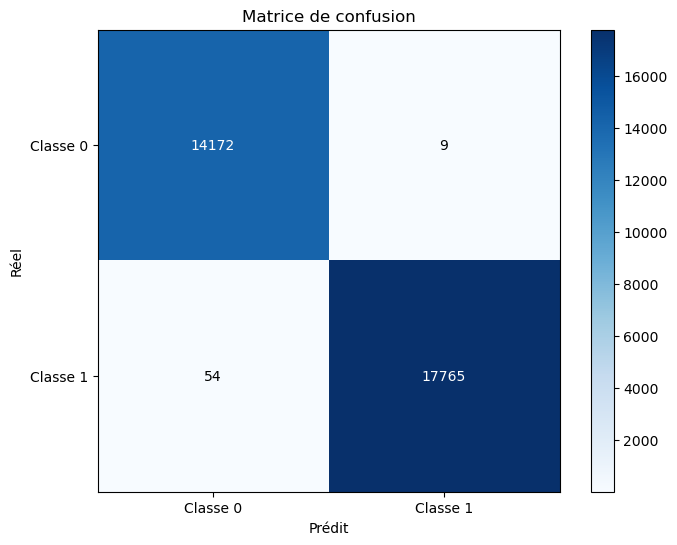

In [29]:
# Figure 4.5
y_pred.reshape(32000,)

y_pred_binary = (y_pred > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matrice de confusion')
plt.colorbar()

classes = ['Classe 0', 'Classe 1']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

plt.xlabel('Prédit')
plt.ylabel('Réel')

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

plt.show()

## Générateur d'Images

### auto encodeur
Après de très nombreuses architectures et un succès limité et incomplet. Ce code permet d'entrainer un auto-encodeur à générer des images.
Le programme de post processing est pas au top mais je n'ai plus le temps de travailler dessus, sa performance optimum est au alentour de T=2.25

Attention très gourmand en calcul → 130 epoch sans callback pour standardiser les figures.
J'utilise un i9-10900 + rtx 3080

Il faut aller voir le fichier: 
génération nouvelle donnée/auto-encodeur/result

pour voir les resultats de ce programme

In [33]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([

            layers.Input(shape=(40, 40, 1)),
            layers.Conv2D(5, (7, 7), activation='relu', padding='same'),
            layers.Conv2D(5, (3, 3), padding='same', activation='relu'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(5, (3, 3), padding='same', activation='relu'),
            layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(15, (3, 3), activation='relu', padding='same'),
            layers.Conv2D(1, (5, 5), activation='relu', padding='same'),

        ])

        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(5, 5, 1)),
            layers.UpSampling2D((2, 2), interpolation='nearest'),
            layers.Conv2D(5, (5, 5), padding='same', activation='relu'),
            layers.UpSampling2D((2, 2), interpolation='nearest'),
            layers.Conv2D(3, (3, 3), padding='same', activation='relu'),
            layers.UpSampling2D((2, 2), interpolation='nearest'),
            layers.Conv2D(3, (5, 5), padding='same', activation='relu'),
            layers.Conv2D(1, (3, 3), padding='same', activation='relu'),

        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder()


# Compile the model
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

(10000, 40, 40, 1)
Epoch 1/130
25/25 [==============================] - 4s 42ms/step - loss: 0.6925 - val_loss: 0.6924
Epoch 2/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 3/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 4/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 5/130
25/25 [==============================] - 0s 11ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 6/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 7/130
25/25 [==============================] - 0s 11ms/step - loss: 0.6924 - val_loss: 0.6924
Epoch 8/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 9/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6923 - val_loss: 0.6924
Epoch 10/130
25/25 [==============================] - 0s 12ms/step - loss: 0.6923

KeyboardInterrupt: 

In [ ]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training and Validation Loss Evolution T = {T:.2f}')
plt.show()

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    img = np.copy(decoded_imgs[i])
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("ratio = {}".format(np.sum(X_test[i].reshape(1600))/1600))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    img= 2*np.random.normal(0.2,0.15,1600) + 1.5*img.reshape(1600) + 6*np.random.normal(-0.1,0.02,1600)
    img[img<=0.45]=0
    img[img>0.45]=1
    img = img.reshape(40,40)
    plt.imshow(img)
    plt.title("ratio = {}".format(np.sum(img.reshape(1600))/1600))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.text(-400,60,f'image original, prédite avec un espace latent dim = 25, et reconstruite avec bruit, T = {T:.2f}',size = 20)
plt.show()

In [ ]:
autoencoder.encoder.summary()

In [ ]:
encoded_imgs1 = autoencoder.encoder(X_train).numpy()
encoded_imgs1.shape

In [ ]:
vec = np.sum(encoded_imgs.reshape(np.shape(encoded_imgs)[0],25),axis=0)
vec1 = np.sum(encoded_imgs1.reshape(np.shape(encoded_imgs1)[0],25),axis=0)

plt.plot(range(25),vec1/np.sum(vec1),label='X_train')
plt.plot(range(25),vec/np.sum(vec),label='X_test')
plt.xlabel('composante nbr')
plt.ylabel('amplitude')
plt.legend()
plt.title(f'vecteur moyen des données T = {T:.2f} dans le sous espace latent')
plt.show()